In [249]:
from pyspark.context import SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.stat import Statistics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd

In [250]:
sc = SparkContext.getOrCreate()

#sqlContext = SparkSession.builder.master("local[*]").appName("appName")\
#                         .config("spark.sql.warehouse.dir", "./spark-warehouse").getOrCreate()


In [251]:
#Reading the data

dataRDD = sc.textFile("../input/HR_comma_sep.csv")\
         .map(lambda line: line.split(","))\
         .filter(lambda line: len(line)>1)\
         .map(lambda line: [x.encode('UTF8') for x in line])\
         .cache()


print dataRDD.take(5)

[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales', 'salary'], ['0.38', '0.53', '2', '157', '3', '0', '1', '0', 'sales', 'low'], ['0.8', '0.86', '5', '262', '6', '0', '1', '0', 'sales', 'medium'], ['0.11', '0.88', '7', '272', '4', '0', '1', '0', 'sales', 'medium'], ['0.72', '0.87', '5', '223', '5', '0', '1', '0', 'sales', 'low']]


In [252]:
header = dataRDD.first()

print header

dataRDD = dataRDD.filter(lambda x: x != header)
all_depts = list(set(dataRDD.map(lambda line: line[-2]).collect()))
all_salaries = list(set(dataRDD.map(lambda line: line[-1]).collect()))
#all_lefts = list(set(dataRDD.map(lambda line: line[-4]).collect()))

['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales', 'salary']


In [253]:
print dataRDD.collect()[:5]

[['0.38', '0.53', '2', '157', '3', '0', '1', '0', 'sales', 'low'], ['0.8', '0.86', '5', '262', '6', '0', '1', '0', 'sales', 'medium'], ['0.11', '0.88', '7', '272', '4', '0', '1', '0', 'sales', 'medium'], ['0.72', '0.87', '5', '223', '5', '0', '1', '0', 'sales', 'low'], ['0.37', '0.52', '2', '159', '3', '0', '1', '0', 'sales', 'low']]


In [254]:
print all_depts
dept_dictionary = {}
for i in all_depts: 
    dept_dictionary[i] = all_depts.index(i)

print all_salaries 

salary_dictionary = {}

for i in all_salaries: 
    salary_dictionary[i] = all_salaries.index(i)
    
print salary_dictionary
print dept_dictionary

['management', 'product_mng', 'hr', 'marketing', 'support', 'sales', 'RandD', 'IT', 'technical', 'accounting']
['high', 'medium', 'low']
{'high': 0, 'medium': 1, 'low': 2}
{'management': 0, 'product_mng': 1, 'hr': 2, 'marketing': 3, 'support': 4, 'sales': 5, 'RandD': 6, 'IT': 7, 'technical': 8, 'accounting': 9}


In [255]:
def replaceString(line):
    """Converts every string member into number"""
    
    line[-2], line[-1] = dept_dictionary[line[-2]], salary_dictionary[line[-1]]
    
    return line

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605,-0.017848,-0.050022
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684,0.004128,0.013002
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064,0.024619,0.001803
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544,0.015081,0.002242
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433,-0.054464,-0.048715
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245,-0.013236,-0.009247
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788,0.023190,0.157898
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000,-0.069184,-0.098119
sales,-0.017848,0.004128,0.024619,0.015081,-0.054464,-0.013236,0.023190,-0.069184,1.000000,0.068667
salary,-0.050022,0.013002,0.001803,0.002242,-0.048715,-0.009247,0.157898,-0.098119,0.068667,1.000000


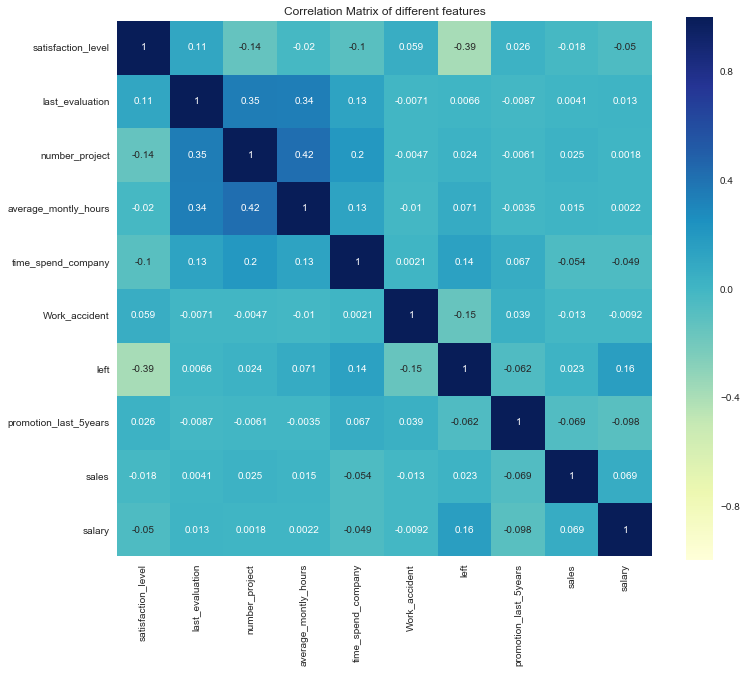

In [256]:
#calculate Correlation of each feature

allNumRDD = dataRDD.map(replaceString).map(lambda line: [float(x) for x in line])
#all number version copy of dataset

correlation = Statistics.corr(allNumRDD, method="pearson")
#print correlation

df = pd.DataFrame(correlation, index=header, columns=header) 

plt.figure(figsize=(12, 10))
sns.heatmap(correlation,
            square=True,
            xticklabels=header,
            yticklabels=header,
            cmap="YlGnBu",
            annot=True,)
            #linewidths=.1)
sns.plt.title('Correlation Matrix of different features')

df #output the correlation table

In [257]:
#The mapreduce procedure output how many hours the employee spend on a single project
#mean time of two group, left(1.0) or not(0.0)
print allNumRDD.collect()[:5]

#workEff = allNumRDD.map(lambda line: (line[3]*12 / line[2]))
workEfficiency = allNumRDD.map(lambda line: (line[-4], (line[3]*12 / line[2])))

meanTime = workEfficiency.map(lambda (k, v): (k, (v, 1))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).map(lambda (k, v): (k, v[0]/v[1])).cache()

meanTime.collect()


[[0.38, 0.53, 2.0, 157.0, 3.0, 0.0, 1.0, 0.0, 5.0, 2.0], [0.8, 0.86, 5.0, 262.0, 6.0, 0.0, 1.0, 0.0, 5.0, 1.0], [0.11, 0.88, 7.0, 272.0, 4.0, 0.0, 1.0, 0.0, 5.0, 1.0], [0.72, 0.87, 5.0, 223.0, 5.0, 0.0, 1.0, 0.0, 5.0, 2.0], [0.37, 0.52, 2.0, 159.0, 3.0, 0.0, 1.0, 0.0, 5.0, 2.0]]


[(0.0, 674.2593104655232), (1.0, 719.2428611433373)]

In [258]:
#two group of work hour, left(1.0) or not(0.0)
leftTimeGroup = workEfficiency.groupByKey().mapValues(list).cache()
#leftTimeGroup.collect()

In [259]:
def classifyRange(hour):
    if hour <= 749.333:
        return 0.0
    elif hour > 749.333 and hour <= 1304.667:
        return 1.0
    elif hout > 1304.667 and hour <= 1860.00:
        return 2.0

In [260]:
#avgHourRange = workEfficiency.map(lambda (k, v): (v, k)).

avgHourProject = workEfficiency.map(lambda (k, v): (k, classifyRange(v)))

avgHourProject.first()


(1.0, 1.0)

In [261]:
#return labeledPoint to do supervised learning
def parsePoint(line):
    """Converts a list of strings into a LabeledPoint"""
    
    #line[-2], line[-1] = dept_dictionary[line[-2]], salary_dictionary[line[-1]]
    replaceString(line)
    datapoints = line[0:-4] + line[-3:]
    
    return LabeledPoint(float(line[-4]),[float(i) for i in datapoints])

In [262]:
parsedData = dataRDD.map(parsePoint)
firstPointFeatures = parsedData.first().features
firstPointLabel = parsedData.first().label
print firstPointFeatures, firstPointLabel


[0.38,0.53,2.0,157.0,3.0,0.0,0.0,5.0,2.0] 1.0


In [263]:
#parse dataset to three part: train, val, test(8: 1: 1)
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights,seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()

nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest 
print parsedData.count()


12068 1489 1442 14999
14999


In [264]:
'''logistic regression'''
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

modelLogReg = LogisticRegressionWithLBFGS.train(parsedTrainData)

#train data
labelsAndPreds_LRtrain = parsedTrainData.map(lambda p: (p.label, modelLogReg.predict(p.features)))
trainErr_LR = labelsAndPreds_LRtrain.filter(lambda (v, p): v != p).count() / float(parsedTrainData.count())
print("Training Error of Training Data = " + str(trainErr_LR))

#test data
labelsAndPreds_LRtest = parsedTestData.map(lambda p: (p.label, modelLogReg.predict(p.features)))
testErr_LR = labelsAndPreds_LRtest.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
print("Training Error of Testing Data= " + str(testErr_LR))

#model.save(sc, "target/tmp/pythonLogisticRegressionWithLBFGSModel")
#sameModel = LogisticRegressionModel.load(sc, "target/tmp/pythonLogisticRegressionWithLBFGSModel")


Training Error of Training Data = 0.182217434538
Training Error of Testing Data= 0.19278779473


In [265]:
'''SVM'''
from pyspark.mllib.classification import SVMWithSGD, SVMModel

# Build the model
modelSVM = SVMWithSGD.train(parsedTrainData, iterations=100)

# Evaluating the model on training data
labelsAndPreds_SVMtrain = parsedTrainData.map(lambda p: (p.label, modelSVM.predict(p.features)))
trainErr_SVM = labelsAndPreds_SVMtrain.filter(lambda (v, p): v != p).count() / float(parsedTrainData.count())
print("Training Error of training data = " + str(trainErr_SVM))

# Evaluating the model on testing data
labelsAndPreds_SVMtest = parsedTestData.map(lambda p: (p.label, modelSVM.predict(p.features)))
testErr_SVM = labelsAndPreds_SVMtest.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
print("Training Error of Testing Data = " + str(testErr_SVM))
#iteration 100: Training Error = 0.243411927878
#iteration 150: Training Error = 0.244105409154
#iteration 200: Training Error = 0.756588072122
#iteration 500: Training Error = 0.243411927878

# model.save(sc, "target/tmp/pythonSVMWithSGDModel")
# sameModel = SVMModel.load(sc, "target/tmp/pythonSVMWithSGDModel")


Training Error of training data = 0.23690752403
Training Error of Testing Data = 0.243411927878


In [266]:
'''decision tree'''

from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

# Train a DecisionTree model.
# Empty categoricalFeaturesInfo indicates all features are continuous.
modelDT = DecisionTree.trainClassifier(parsedTrainData, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=32)


# Evaluate model on train instances and compute train error
predictions_DTtrain = modelDT.predict(parsedTrainData.map(lambda x: x.features))
labelsAndPredictions_DTtrain = parsedTrainData.map(lambda lp: lp.label).zip(predictions_DTtrain)
trainErr_DT = labelsAndPredictions_DTtrain.filter(lambda (v, p): v != p).count() / float(parsedTrainData.count())
print('Train Error of Decision Tree = ' + str(trainErr_DT))

# Evaluate model on test instances and compute test error
predictions_DTtest = modelDT.predict(parsedTestData.map(lambda x: x.features))
labelsAndPredictions_DTtest = parsedTestData.map(lambda lp: lp.label).zip(predictions_DTtest)
testErr_DT = labelsAndPredictions_DTtest.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
print('Test Error of Decision Tree = ' + str(testErr_DT))
print('Learned classification tree model:')
print(modelDT.toDebugString())

# Save and load model
# model.save(sc, "target/tmp/myDecisionTreeClassificationModel")
# sameModel = DecisionTreeModel.load(sc, "target/tmp/myDecisionTreeClassificationModel")

Train Error of Decision Tree = 0.0272621809745
Test Error of Decision Tree = 0.0263522884882
Learned classification tree model:
DecisionTreeModel classifier of depth 5 with 53 nodes
  If (feature 0 <= 0.47)
   If (feature 2 <= 2.0)
    If (feature 1 <= 0.57)
     If (feature 1 <= 0.44)
      Predict: 0.0
     Else (feature 1 > 0.44)
      If (feature 3 <= 125.0)
       Predict: 0.0
      Else (feature 3 > 125.0)
       Predict: 1.0
    Else (feature 1 > 0.57)
     If (feature 3 <= 272.0)
      If (feature 7 <= 7.0)
       Predict: 0.0
      Else (feature 7 > 7.0)
       Predict: 0.0
     Else (feature 3 > 272.0)
      If (feature 7 <= 3.0)
       Predict: 1.0
      Else (feature 7 > 3.0)
       Predict: 0.0
   Else (feature 2 > 2.0)
    If (feature 0 <= 0.13)
     If (feature 1 <= 0.76)
      If (feature 0 <= 0.1)
       Predict: 1.0
      Else (feature 0 > 0.1)
       Predict: 0.0
     Else (feature 1 > 0.76)
      If (feature 3 <= 240.0)
       Predict: 0.0
      Else (feature 3 > 24

In [267]:
'''Random Forest'''
from pyspark.mllib.tree import RandomForest, RandomForestModel

# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Note: Use larger numTrees in practice.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
modelRF = RandomForest.trainRegressor(parsedTrainData, categoricalFeaturesInfo={},
                                    numTrees=3, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=4, maxBins=32)

# Evaluate model on test instances and compute test error
predictions_RFtrain = modelRF.predict(parsedTrainData.map(lambda x: x.features))
labelsAndPredictions_RFtrain = parsedTrainData.map(lambda lp: lp.label).zip(predictions_RFtrain)
trainMSE_RF = labelsAndPredictions_RFtrain.map(lambda (v, p): (v - p) * (v - p)).sum() /\
    float(parsedTrainData.count())
print('Train Mean Squared Error = ' + str(trainMSE_RF))

# Evaluate model on test instances and compute test error
predictions_RFtest = modelRF.predict(parsedTestData.map(lambda x: x.features))
labelsAndPredictions_RFtest = parsedTestData.map(lambda lp: lp.label).zip(predictions_RFtest)
testMSE_RF = labelsAndPredictions_RFtest.map(lambda (v, p): (v - p) * (v - p)).sum() /\
    float(parsedTestData.count())
print('Test Mean Squared Error = ' + str(testMSE_RF))
print('Learned regression forest model:')
print(modelRF.toDebugString())

# Save and load model
# model.save(sc, "target/tmp/myRandomForestRegressionModel")
# sameModel = RandomForestModel.load(sc, "target/tmp/myRandomForestRegressionModel")

Train Mean Squared Error = 0.0574612014634
Test Mean Squared Error = 0.0592650213002
Learned regression forest model:
TreeEnsembleModel regressor with 3 trees

  Tree 0:
    If (feature 2 <= 2.0)
     If (feature 4 <= 3.0)
      If (feature 0 <= 0.47)
       If (feature 1 <= 0.57)
        Predict: 0.9606177606177606
       Else (feature 1 > 0.57)
        Predict: 0.0
      Else (feature 0 > 0.47)
       If (feature 0 <= 0.64)
        Predict: 0.018633540372670808
       Else (feature 0 > 0.64)
        Predict: 0.05747126436781609
     Else (feature 4 > 3.0)
      If (feature 1 <= 0.93)
       If (feature 4 <= 5.0)
        Predict: 0.12337662337662338
       Else (feature 4 > 5.0)
        Predict: 0.0
      Else (feature 1 > 0.93)
       If (feature 7 <= 7.0)
        Predict: 0.2
       Else (feature 7 > 7.0)
        Predict: 1.0
    Else (feature 2 > 2.0)
     If (feature 3 <= 272.0)
      If (feature 4 <= 3.0)
       If (feature 0 <= 0.1)
        Predict: 1.0
       Else (feature 0 > 

In [268]:
models = pd.DataFrame({
        'Model'          : ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest'],
        'Training_Error' : [trainErr_LR, trainErr_SVM, trainErr_DT, trainMSE_RF],
        'Testing_Error'  : [testErr_LR, testErr_SVM, testErr_DT, testMSE_RF]
    })
models.sort_values(by='Testing_Error', ascending=True)

,Model,Testing_Error,Training_Error
2,Decision Tree,0.026352,0.027262
3,Random Forest,0.059265,0.057461
0,Logistic Regression,0.192788,0.182217
1,SVM,0.243412,0.236908
